# Gradient Boosting

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt

import sklearn
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model as lm
from sklearn import model_selection as ms
sklearn.set_config(print_changed_only=False)

import copy

import import_ipynb

from _Self_Written_Functions_Sheet import (conditions_edit, nbrhd_rank, drop_nbrhd,
totallivsf_add, drop_grlivarea, bsmtfin_add, drop_bsmtfinsf12, totalporchsf_add,
drop_porches, yrsremodtosold_add, drop_yrsoldremod, fireplace_yes, drop_fireplaces,
pool_yes, drop_poolarea, totalbaths_add, drop_baths, totalbsmtbaths_add,
drop_bsmtbaths)

from _Self_Written_Functions_Sheet import (dum_scale, use_og_data, comb_list_generator,
                                           apply_comb_list, rmse)

importing Jupyter notebook from _Self_Written_Functions_Sheet.ipynb


In [2]:
hp_train = pd.read_csv('..\hp_2a_ranked_edited_train.csv', index_col=0)
hp_test = pd.read_csv('..\hp_2a_ranked_edited_test.csv', index_col=0)
hp_logsp = pd.read_csv('..\hp_1a_no_imputation_logsaleprice.csv', index_col=0)
hp_saleprice = pd.read_csv('..\hp_1a_no_imputation_saleprice.csv', index_col=0)

# saving train index
hp_index = hp_train.index

combo_nonedit = pd.concat([hp_train, hp_test])
combo_nonedit.columns = hp_train.columns

# convert all possible numeric types to numeric
for col in combo_nonedit.columns: 
    combo_nonedit[col] = combo_nonedit[col].astype('float', errors='ignore')

combo_cols = list(combo_nonedit.columns)

combo = copy.deepcopy(combo_nonedit)

combo

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,2_STORY_1946_NEWER,RL,65.0,8450.0,1.0,0.0,Reg,Lvl,3.0,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,2003.0,2003.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,4.0,3.0,PConc,4.0,3.0,1.0,6.0,706.0,1.0,0.0,150.0,856.0,GasA,5.0,1.0,5.0,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,4.0,8.0,7.0,0.0,None,Attchd,2003.0,2.0,2.0,548.0,3.0,3.0,3.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,2.0,2008.0,WD,Normal
1,1_STORY_1946_NEWER_ALL_STYLES,RL,80.0,9600.0,1.0,0.0,Reg,Lvl,3.0,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6.0,8.0,1976.0,1976.0,Gable,CompShg,MetalSd,MetalSd,None,0.0,3.0,3.0,CBlock,4.0,3.0,4.0,5.0,978.0,1.0,0.0,284.0,1262.0,GasA,5.0,1.0,5.0,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,3.0,6.0,7.0,1.0,TA,Attchd,1976.0,2.0,2.0,460.0,3.0,3.0,3.0,298.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,5.0,2007.0,WD,Normal
2,2_STORY_1946_NEWER,RL,68.0,11250.0,1.0,0.0,IR1,Lvl,3.0,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,2001.0,2002.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,4.0,3.0,PConc,4.0,3.0,2.0,6.0,486.0,1.0,0.0,434.0,920.0,GasA,5.0,1.0,5.0,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,4.0,6.0,7.0,1.0,TA,Attchd,2001.0,2.0,2.0,608.0,3.0,3.0,3.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,9.0,2008.0,WD,Normal
3,2_STORY_1945_OLDER,RL,60.0,9550.0,1.0,0.0,IR1,Lvl,3.0,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7.0,5.0,1915.0,1970.0,Gable,CompShg,Wd Sdng,WdShing,None,0.0,3.0,3.0,BrkTil,3.0,4.0,1.0,5.0,216.0,1.0,0.0,540.0,756.0,GasA,4.0,1.0,5.0,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,4.0,7.0,7.0,1.0,Gd,Detchd,1998.0,1.0,3.0,642.0,3.0,3.0,3.0,0.0,35.0,272.0,0.0,0.0,0.0,0.0,0.0,None,0.0,2.0,2006.0,WD,Abnorml
4,2_STORY_1946_NEWER,RL,84.0,14260.0,1.0,0.0,IR1,Lvl,3.0,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8.0,5.0,2000.0,2000.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,4.0,3.0,PConc,4.0,3.0,3.0,6.0,655.0,1.0,0.0,490.0,1145.0,GasA,5.0,1.0,5.0,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,4.0,9.0,7.0,1.0,TA,Attchd,2000.0,2.0,3.0,836.0,3.0,3.0,3.0,192.0,84.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,12.0,2008.0,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2912,2_STORY_PUD_1946_NEWER,RM,21.0,1936.0,1.0,0.0,Reg,Lvl,3.0,Inside,Gtl,MeadowV,Norm,Norm,TwnhsI,2Story,4.0,7.0,1970.0,1970.0,Gable,CompShg,CemntBd,CemntBd,None,0.0,3.0,3.0,CBlock,3.0,3.0,1.0,1.0,0.0,1.0,0.0,546.0,546.0,GasA,4.0,1.0,5.0,546.0,546.0,0.0,1092.0,0.0,0.0,1.0,1.0,3.0,1.0,3.0,5.0,7.0,0.0,None,None,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,6.0,2006.0,WD,Normal
2913,2_STORY_PUD_1946_NEWER,RM,21.0,1894.0,1.0,0.0,Reg,Lvl,3.0,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4.0,5.0,1970.0,1970.0,Gable,CompShg,CemntBd,CemntBd,None,0.0,3.0,3.0,CBlock,3.0,3.0,1.0,3.0,252.0,1.0,0.0,294.0,546.0,GasA,3.0,1.0,5.0,546.0,546.0,0.0,1092.0,0.0,0.0,1.0,1.0,3.0,1.0,3.0,6.0,7.0,0.0,None,CarPort,1970.0,1.0,1.0,286.0,3.0,3.0,3.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,4.0,20

In [3]:
# make copies of the original df to edit each individually according to the best scores/feat eng pair
gbm_df = copy.deepcopy(combo_nonedit)

# copy and paste the functions from the dictionary results above
gbm_feat_eng = [bsmtfin_add, totalbaths_add, totalbsmtbaths_add, conditions_edit, drop_porches,
                drop_yrsoldremod, drop_poolarea, drop_bsmtbaths]

for feat in gbm_feat_eng:
    feat(gbm_df)

# dummify and scale the dataset
hp_full_strd = copy.deepcopy(dum_scale(gbm_df))

hp_full_strd_to_use = copy.deepcopy(hp_full_strd.loc[hp_index])

hp_full_strd_to_use

,TotalBsmtBaths,TotalBaths,BsmtFin,LotFrontage,LotArea,Street,Alley,Utilities,OverallQual,OverallCond,YearBuilt,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,PoolQC,Fence,MiscVal,MoSold,MSSubClass_1_1_2_STORY_PUD_ALL_AGES,MSSubClass_1_1_2_STORY_UNFINISHED_ALL_AGES,MSSubClass_1_STORY_1945_OLDER,MSSubClass_1_STORY_1946_NEWER_ALL_STYLES,MSSubClass_1_STORY_PUD_Planned_Unit_Development_1946_NEWER,MSSubClass_1_STORY_W_FINISHED_ATTIC_ALL_AGES,MSSubClass_2_1_2_STORY_ALL_AGES,MSSubClass_2_FAMILY_CONVERSION_ALL_STYLES_AND_AGES,MSSubClass_2_STORY_1945_OLDER,MSSubClass_2_STORY_1946_NEWER,MSSubClass_2_STORY_PUD_1946_NEWER,MSSubClass_DUPLEX_ALL_STYLES_AND_AGES,MSSubClass_PUD_MULTILEVEL_INCL_SPLIT_LEV_FOYER,MSSubClass_SPLIT_FOYER,MSSubClass_SPLIT_OR_MULTI_LEVEL,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRA,Condition1_RRN,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRA,Condition2_RRN,BldgType_2fmCon,BldgType_Duplex,BldgType_TwnhsE,BldgType_TwnhsI,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_BrkComm,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CemntBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_WdShing,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.333333,0.5,1.0,0.150685,0.033420,1.0,0.0,1.0,0.666667,0.500,0.949275,0.122500,0.666667,0.50,0.8,0.75,0.25,1.000000,0.176060,0.166667,0.000000,0.064212,0.168008,1.00,1.0,1.00,0.109641,0.413559,0.0,0.289015,0.50,0.5,0.375,0.333333,0.666667,0.461538,1.000000,0.00,0.996517,0.666667,0.4,0.368280,0.6,0.6,1.0,0.000000,0.0,0.0,0.000000,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0

In [4]:
state = 0

# setting up train and test sets
xtrain, xtest, ytrain, ytest = ms.train_test_split(hp_full_strd_to_use,
                                                   hp_logsp,
                                                   test_size=0.2,
                                                   random_state=state)

# Must flatten to fit
ytrain = ytrain.values.flatten()

# using standard kfold split
n_folds = ms.KFold(n_splits=5, random_state=state, shuffle=True)

In [16]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

gbm = GradientBoostingRegressor(random_state=0)

# parameters to use
nestimators = [10, 20, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
sub_sample = [0.1, 0.25, 0.5, 0.75, 1]
minsamsplt = [2, 3, 4, 5]
minsamlf = [1, 2, 3, 4, 5]
maxdepth = [5, 10, 20, 40, 50, 60, 100, 150, 200]
warmstart = [True]

gparam_gbm = {'n_estimators': nestimators,
              'subsample': sub_sample,
              'min_samples_split': minsamsplt,
              'min_samples_leaf': minsamlf,
              'max_depth': maxdepth,
              'warm_start': warmstart}

# setting parameters
gs_gbm = ms.GridSearchCV(gbm, gparam_gbm, cv=n_folds, refit=True, n_jobs=-1,
                           scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_gbm.fit(xtrain, ytrain)

# setting up dataframe for results
train_scores.append(gs_gbm.best_estimator_.score(xtrain, ytrain))
test_scores.append(gs_gbm.best_estimator_.score(xtest, ytest))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_gbm, ytrain, xtrain))
test_rmse.append(rmse(gs_gbm, ytest, xtest))

# add the best parameters to the df
best_par_list.append(gs_gbm.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
gbm_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
gbm_res_df = pd.DataFrame(gbm_list_results).T
gbm_res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
gbm_res_df = pd.concat([gbm_res_df, best_par_df], axis=1, sort=False)

gbm_res_df

Wall time: 1h 52min 20s


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,max_depth,min_samples_leaf,min_samples_split,n_estimators,subsample,warm_start
0,0.977238,0.924744,0.059799,0.112934,-0.053135,10,5,2,100,0.25,True


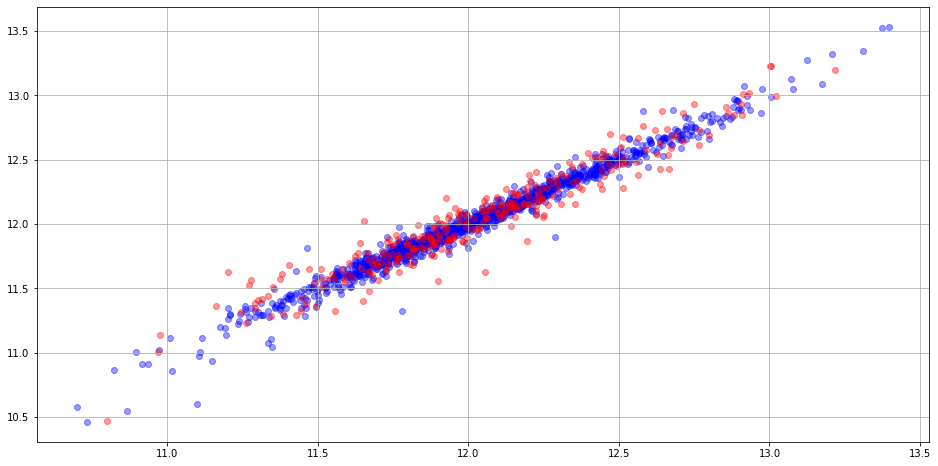

In [17]:
plt.figure(figsize=(16, 8))
plt.scatter(gs_gbm.best_estimator_.predict(xtrain), ytrain, color='blue', alpha=0.4)
plt.scatter(gs_gbm.best_estimator_.predict(xtest), ytest, color='red', alpha=0.4)
plt.grid(which='both')

In [18]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

gbm = GradientBoostingRegressor(random_state=0)

# parameters to use
nestimators = [10, 25, 50, 75, 100, 125, 150, 175, 200]
sub_sample = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
minsamsplt = [2, 3]
minsamlf = [3, 4, 5, 6, 7, 8]
maxdepth = [8, 9, 10, 11, 12]
warmstart = [True]

gparam_gbm = {'n_estimators': nestimators,
              'subsample': sub_sample,
              'min_samples_split': minsamsplt,
              'min_samples_leaf': minsamlf,
              'max_depth': maxdepth,
              'warm_start': warmstart}

# setting parameters
gs_gbm = ms.GridSearchCV(gbm, gparam_gbm, cv=n_folds, refit=True, n_jobs=-1,
                           scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_gbm.fit(xtrain, ytrain)

# setting up dataframe for results
train_scores.append(gs_gbm.best_estimator_.score(xtrain, ytrain))
test_scores.append(gs_gbm.best_estimator_.score(xtest, ytest))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_gbm, ytrain, xtrain))
test_rmse.append(rmse(gs_gbm, ytest, xtest))

# add the best parameters to the df
best_par_list.append(gs_gbm.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
gbm_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
gbm_res_df = pd.DataFrame(gbm_list_results).T
gbm_res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
gbm_res_df = pd.concat([gbm_res_df, best_par_df], axis=1, sort=False)

gbm_res_df

Wall time: 4min 23s


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,max_depth,min_samples_leaf,min_samples_split,n_estimators,subsample,warm_start
0,0.972888,0.917683,0.065263,0.118113,-0.05285,9,4,2,75,0.25,True


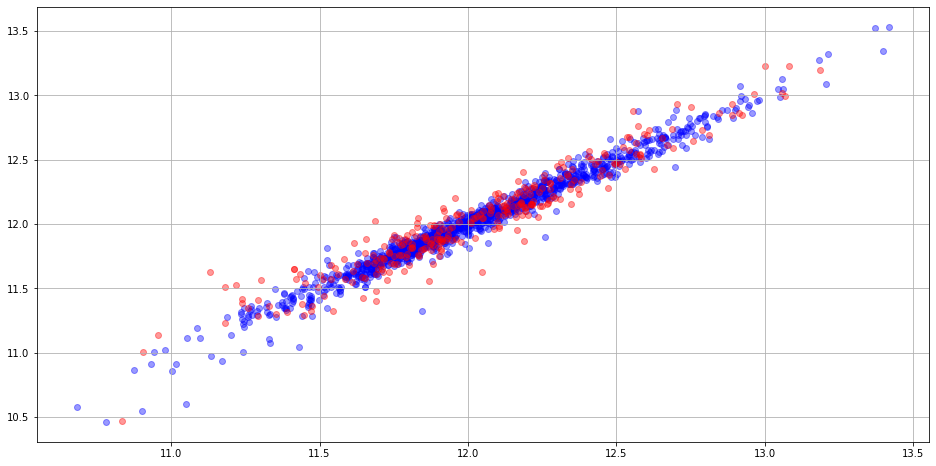

In [19]:
plt.figure(figsize=(16, 8))
plt.scatter(gs_gbm.best_estimator_.predict(xtrain), ytrain, color='blue', alpha=0.4)
plt.scatter(gs_gbm.best_estimator_.predict(xtest), ytest, color='red', alpha=0.4)
plt.grid(which='both')

In [21]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

gbm = GradientBoostingRegressor(random_state=0)

# parameters to use
nestimators = [50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
sub_sample = [0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3]
minsamsplt = [2, 3]
minsamlf = [3, 4, 5, 6]
maxdepth = [7, 8, 9, 10, 11]
warmstart = [True]

gparam_gbm = {'n_estimators': nestimators,
              'subsample': sub_sample,
              'min_samples_split': minsamsplt,
              'min_samples_leaf': minsamlf,
              'max_depth': maxdepth,
              'warm_start': warmstart}

# setting parameters
gs_gbm = ms.GridSearchCV(gbm, gparam_gbm, cv=n_folds, refit=True, n_jobs=-1,
                           scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_gbm.fit(xtrain, ytrain)

# setting up dataframe for results
train_scores.append(gs_gbm.best_estimator_.score(xtrain, ytrain))
test_scores.append(gs_gbm.best_estimator_.score(xtest, ytest))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_gbm, ytrain, xtrain))
test_rmse.append(rmse(gs_gbm, ytest, xtest))

# add the best parameters to the df
best_par_list.append(gs_gbm.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
gbm_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
gbm_res_df = pd.DataFrame(gbm_list_results).T
gbm_res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
gbm_res_df = pd.concat([gbm_res_df, best_par_df], axis=1, sort=False)

gbm_res_df

Wall time: 4min 13s


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,max_depth,min_samples_leaf,min_samples_split,n_estimators,subsample,warm_start
0,0.971225,0.917959,0.067235,0.117915,-0.05068,9,4,2,70,0.25,True


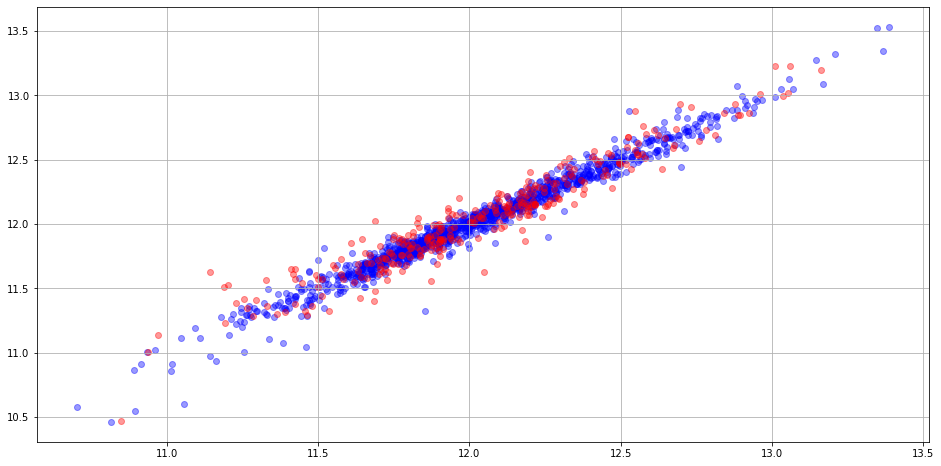

In [22]:
plt.figure(figsize=(16, 8))
plt.scatter(gs_gbm.best_estimator_.predict(xtrain), ytrain, color='blue', alpha=0.4)
plt.scatter(gs_gbm.best_estimator_.predict(xtest), ytest, color='red', alpha=0.4)
plt.grid(which='both')

In [5]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

gbm = GradientBoostingRegressor(random_state=0)

# parameters to use
nestimators = [66, 67, 68, 69, 70, 71, 72, 73, 74]
sub_sample = [0.245, 0.246, 0.247, 0.248, 0.249, 0.25, 0.251, 0.252, 0.253, 0.254, 0.255]
minsamsplt = [2, 3]
minsamlf = [3, 4, 5, 6]
maxdepth = [7, 8, 9, 10, 11]
warmstart = [True]

gparam_gbm = {'n_estimators': nestimators,
              'subsample': sub_sample,
              'min_samples_split': minsamsplt,
              'min_samples_leaf': minsamlf,
              'max_depth': maxdepth,
              'warm_start': warmstart}

# setting parameters
gs_gbm = ms.GridSearchCV(gbm, gparam_gbm, cv=n_folds, refit=True, n_jobs=-1,
                         scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_gbm.fit(xtrain, ytrain)

# setting up dataframe for results
train_scores.append(gs_gbm.best_estimator_.score(xtrain, ytrain))
test_scores.append(gs_gbm.best_estimator_.score(xtest, ytest))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_gbm, ytrain, xtrain))
test_rmse.append(rmse(gs_gbm, ytest, xtest))

# add the best parameters to the df
best_par_list.append(gs_gbm.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
gbm_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
gbm_res_df = pd.DataFrame(gbm_list_results).T
gbm_res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
gbm_res_df = pd.concat([gbm_res_df, best_par_df], axis=1, sort=False)

gbm_res_df

Wall time: 3min 12s


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,max_depth,min_samples_leaf,min_samples_split,n_estimators,subsample,warm_start
0,0.971225,0.917959,0.067235,0.117915,-0.05068,9,4,2,70,0.25,True


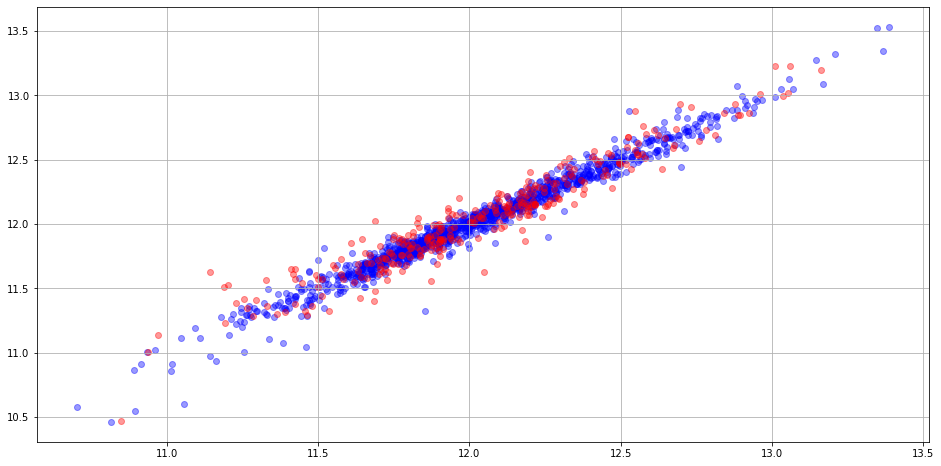

In [6]:
plt.figure(figsize=(16, 8))
plt.scatter(gs_gbm.best_estimator_.predict(xtrain), ytrain, color='blue', alpha=0.4)
plt.scatter(gs_gbm.best_estimator_.predict(xtest), ytest, color='red', alpha=0.4)
plt.grid(which='both')

# Using reduced dataset

In [7]:
sorted_importance_gbm = sorted(zip(hp_full_strd_to_use.columns,
                                   gs_gbm.best_estimator_.feature_importances_),
                               key=lambda t:t[1], reverse=True)

filtered_sorted_importance_gbm = [x for x in sorted_importance_gbm if x[1]>0]

df_filter_sort_gbm = [x[0] for x in filtered_sorted_importance_gbm]

df_filter_sort_gbm

['OverallQual',
 'GrLivArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'GarageArea',
 'KitchenQual',
 'LotArea',
 'BsmtFinSF1',
 'OverallCond',
 'CentralAir',
 'YearBuilt',
 'GarageYrBlt',
 'GarageFinish',
 'Fireplaces',
 'BsmtUnfSF',
 'GarageCars',
 'ExterQual',
 '2ndFlrSF',
 'Neighborhood_IDOTRR',
 'LotFrontage',
 'TotalBaths',
 'GarageCond',
 'TotRmsAbvGrd',
 'HeatingQC',
 'MasVnrArea',
 'SaleCondition_Normal',
 'ExterCond',
 'WoodDeckSF',
 'GarageType_Detchd',
 'BsmtFinType1',
 'MSZoning_RL',
 'BsmtQual',
 'LotShape_Reg',
 'RoofStyle_Hip',
 'MSZoning_RM',
 'GarageQual',
 'BsmtExposure',
 'Foundation_CBlock',
 'Fence',
 'GarageType_Attchd',
 'Neighborhood_OldTown',
 'Functional',
 'FireplaceQu_None',
 'PavedDrive',
 'Exterior2nd_Wd Sdng',
 'BedroomAbvGr',
 'FireplaceQu_TA',
 'MSSubClass_1-STORY 1945 & OLDER',
 'KitchenAbvGr',
 'Condition1_Norm',
 'BsmtFin',
 'TotalBsmtBaths',
 'Exterior1st_BrkFace',
 'BsmtFinSF2',
 'SaleType_WD',
 'Alley',
 'Neighborhood_Crawfor',
 'MoSold_Dec',
 'HalfBath',
 

In [8]:
hp_fullstrd_filtrsrt = hp_full_strd_to_use[df_filter_sort_gbm]
hp_fullstrd_filtrsrt

,OverallQual,GrLivArea,TotalBsmtSF,1stFlrSF,GarageArea,KitchenQual,LotArea,BsmtFinSF1,OverallCond,CentralAir,YearBuilt,GarageYrBlt,GarageFinish,Fireplaces,BsmtUnfSF,GarageCars,ExterQual,2ndFlrSF,Neighborhood_IDOTRR,LotFrontage,TotalBaths,GarageCond,TotRmsAbvGrd,HeatingQC,MasVnrArea,SaleCondition_Normal,ExterCond,WoodDeckSF,GarageType_Detchd,BsmtFinType1,MSZoning_RL,BsmtQual,LotShape_Reg,RoofStyle_Hip,MSZoning_RM,GarageQual,BsmtExposure,Foundation_CBlock,Fence,GarageType_Attchd,Neighborhood_OldTown,Functional,FireplaceQu_None,PavedDrive,Exterior2nd_Wd Sdng,BedroomAbvGr,FireplaceQu_TA,MSSubClass_1-STORY 1945 & OLDER,KitchenAbvGr,Condition1_Norm,BsmtFin,TotalBsmtBaths,Exterior1st_BrkFace,BsmtFinSF2,SaleType_WD,Alley,Neighborhood_Crawfor,MoSold_Dec,HalfBath,SaleCondition_Partial,MoSold_Jul,LandContour_Lvl,FullBath,Exterior1st_Wd Sdng,FireplaceQu_Gd,FireplaceQu_Po,MSSubClass_2-STORY 1946 & NEWER,MSSubClass_1-1/2 STORY FINISHED ALL AGES,Neighborhood_Edwards,LotConfig_Inside,Exterior2nd_MetalSd,BsmtCond,LandContour_HLS,MasVnrType_BrkFace,Exterior2nd_WdShing,RoofStyle_Gable,Neighborhood_Sawyer,Electrical,LowQualFinSF,Exterior2nd_HdBoard,Neighborhood_StoneBr,Neighborhood_NAmes,MoSold_Feb,MoSold_Nov,SaleCondition_Family,Exterior2nd_VinylSd,Neighborhood_ClearCr,MSSubClass_2-STORY 1945 & OLDER,MasVnrType_None,MoSold_Jun,Neighborhood_NoRidge,Neighborhood_Somerst,Foundation_PConc,MoSold_Oct,MasVnrType_Stone,HouseStyle_1Story,Neighborhood_BrkSide,BsmtFinType2,Exterior2nd_Plywood,Neighborhood_NridgHt,HouseStyle_SLvl,Neighborhood_NWAmes,BldgType_TwnhsE,LotConfig_CulDSac,Exterior1st_VinylSd,Neighborhood_CollgCr,GarageType_Basment,HouseStyle_2Story,MoSold_Aug,MoSold_Sep,LandSlope_Mod,Neighborhood_Mitchel,MiscFeature_None,Exterior1st_HdBoard,LotConfig_FR2,SaleCondition_Alloca,Exterior2nd_BrkFace,Exterior2nd_Stucco,Neighborhood_SWISU,MoSold_May,Exterior1st_WdShing,Neighborhood_Timber,Foundation_Slab,MoSold_Mar,MSSubClass_SPLIT OR MULTI-LEVEL,MiscVal,Neighborhood_Gilbert,Condition1_Feedr,Condition1_RRA,SaleType_New,GarageType_CarPort,MSSubClass_2-STORY PUD - 1946 & NEWER,GarageType_BuiltIn,MSZoning_FV,Exterior1st_MetalSd,BldgType_TwnhsI,MSSubClass_1-STORY 1946 & NEWER ALL STYLES
0,0.666667,0.289015,0.168008,0.109641,0.368280,0.666667,0.033420,0.176060,0.500,1.0,0.949275,0.996517,0.666667,0.00,0.064212,0.4,0.666667,0.413559,0.0,0.150685,0.5,0.6,0.461538,1.00,0.122500,1.0,0.50,0.000000,0.0,1.000000,1.0,0.8,1.0,0.0,0.0,0.6,0.25,0.0,0.0,1.0,0.0,1.000000,1.0,1.0,0.0,0.375,0.0,0.0,0.333333,1.0,1.0,0.333333,0.0,0.000000,1.0,0.0,0.0,0.0,0.5,0.0,0.0,1.0,0.50,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.75,0.0,1.0,0.0,1.0,0.0,1.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.555556,0.194917,0.247694,0.194917,0.309140,0.333333,0.038795,0.243890,0.875,1.0,0.753623,0.983085,0.666667,0.25,0.121575,0.4,0.333333,0.000000,0.0,0.202055,0.4,0.6,0.307692,1.00,0.000000,1.0,0.50,0.209270,0.0,0.833333,1.0,0.8,1.0,0.0,0.0,0.6,1.00,1.0,0.0,1.0,0.0,1.000000,0.0,1.0,0.0,0.375,1.0,0.0,0.333333,0.0,1.0,0.166667,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.75,0.0,0.0,0.0,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.666667,0.304978,0.180569,0.123083,0.408602,0.666667,0.046507,0.121197,0.500,1.0,0.934783,0.995522,0.666667,0.25,0.185788,0.4,0.666667,0.419370,0.0,0.160959,0.5,0.6,0.307692,1.00,0.101250,1.0,0.50,0.000000,0.0,1.000000,1.0,0.8,0.0,0.0,0.0,0.6,0.50,0.0,0.0,1.0,0.0,1.000000,0.0,1.0,0.0,0.375,1.0,0.0,0.333333,1.0,1.0,0.333333,0.0,0.000000,1.0,0.0,0.0,0.0,0.5,0.0,0.0,1.0,0.50,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.75,0.0,1.0,0.0,1.0,0

In [9]:
state = 0

# setting up train and test sets
xtrain_fs, xtest_fs, ytrain_fs, ytest_fs = ms.train_test_split(hp_fullstrd_filtrsrt,
                                                               hp_logsp,
                                                               test_size=0.2,
                                                               random_state=state)

# Must flatten to fit
ytrain_fs = ytrain_fs.values.flatten()

In [31]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

# parameters to use
nestimators = [10, 20, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
sub_sample = [0.1, 0.25, 0.5, 0.75, 1]
minsamsplt = [2, 3, 4, 5]
minsamlf = [1, 2, 3, 4, 5]
maxdepth = [5, 10, 20, 40, 50, 60, 100, 150, 200]
warmstart = [True]

gparam_gbm_fs = {'n_estimators': nestimators,
              'subsample': sub_sample,
              'min_samples_split': minsamsplt,
              'min_samples_leaf': minsamlf,
              'max_depth': maxdepth,
              'warm_start': warmstart}

# setting parameters
gs_gbm_fs = ms.GridSearchCV(gbm, gparam_gbm_fs, cv=n_folds, refit=True, n_jobs=-1,
                            scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_gbm_fs.fit(xtrain_fs, ytrain_fs)

# setting up dataframe for results
train_scores.append(gs_gbm_fs.best_estimator_.score(xtrain_fs, ytrain_fs))
test_scores.append(gs_gbm_fs.best_estimator_.score(xtest_fs, ytest_fs))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_gbm_fs, ytrain_fs, xtrain_fs))
test_rmse.append(rmse(gs_gbm_fs, ytest_fs, xtest_fs))

# add the best parameters to the df
best_par_list.append(gs_gbm_fs.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
gbm_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
gbm_res_df = pd.DataFrame(gbm_list_results).T
gbm_res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
gbm_res_df = pd.concat([gbm_res_df, best_par_df], axis=1, sort=False)

gbm_res_df

Wall time: 1h 33min 30s


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,max_depth,min_samples_leaf,min_samples_split,n_estimators,subsample,warm_start
0,0.981961,0.90998,0.053234,0.123515,-0.070281,5,1,4,150,0.25,True


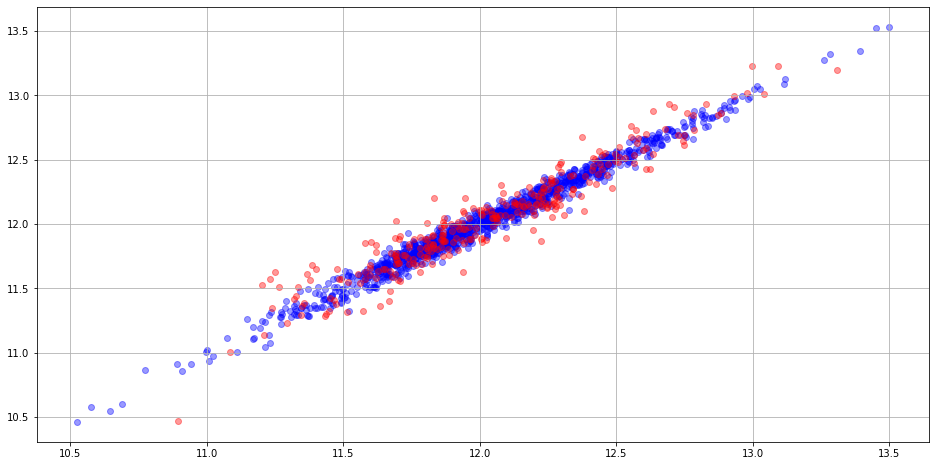

In [33]:
plt.figure(figsize=(16, 8))
plt.scatter(gs_gbm_fs.best_estimator_.predict(xtrain_fs), ytrain_fs, color='blue', alpha=0.4)
plt.scatter(gs_gbm_fs.best_estimator_.predict(xtest_fs), ytest_fs, color='red', alpha=0.4)
plt.grid(which='both')

In [10]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

# parameters to use
nestimators = [100, 125, 150, 175, 200]
sub_sample = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
minsamsplt = [2, 3, 4, 5, 6]
minsamlf = [1, 2, 3, 4]
maxdepth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
warmstart = [True]

gparam_gbm_fs = {'n_estimators': nestimators,
                 'subsample': sub_sample,
                 'min_samples_split': minsamsplt,
                 'min_samples_leaf': minsamlf,
                 'max_depth': maxdepth,
                 'warm_start': warmstart}

# setting parameters
gs_gbm_fs = ms.GridSearchCV(gbm, gparam_gbm_fs, cv=n_folds, refit=True, n_jobs=-1,
                             scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_gbm_fs.fit(xtrain_fs, ytrain_fs)

# setting up dataframe for results
train_scores.append(gs_gbm_fs.best_estimator_.score(xtrain_fs, ytrain_fs))
test_scores.append(gs_gbm_fs.best_estimator_.score(xtest_fs, ytest_fs))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_gbm_fs, ytrain_fs, xtrain_fs))
test_rmse.append(rmse(gs_gbm_fs, ytest_fs, xtest_fs))

# add the best parameters to the df
best_par_list.append(gs_gbm_fs.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
gbm_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
gbm_res_df = pd.DataFrame(gbm_list_results).T
gbm_res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
gbm_res_df = pd.concat([gbm_res_df, best_par_df], axis=1, sort=False)

gbm_res_df

Wall time: 11min 22s


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,max_depth,min_samples_leaf,min_samples_split,n_estimators,subsample,warm_start
0,0.948308,0.932282,0.090115,0.107128,-0.017014,2,2,6,200,0.45,True


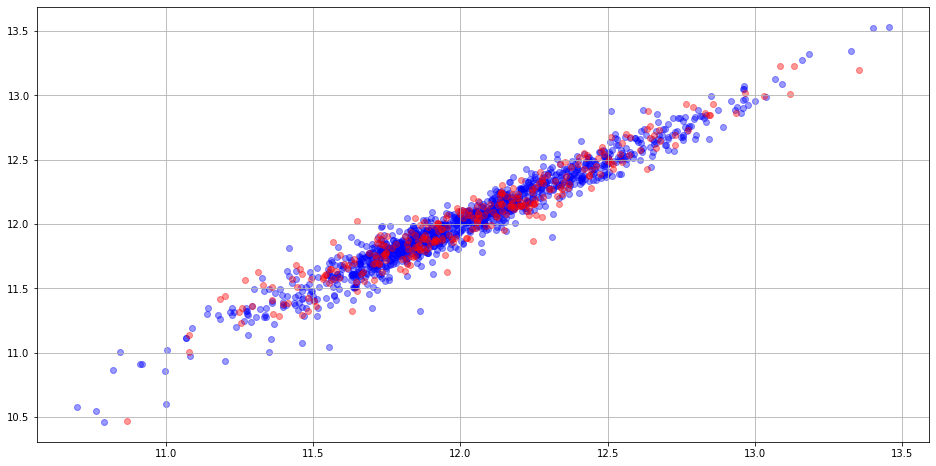

In [11]:
plt.figure(figsize=(16, 8))
plt.scatter(gs_gbm_fs.best_estimator_.predict(xtrain_fs), ytrain_fs, color='blue', alpha=0.4)
plt.scatter(gs_gbm_fs.best_estimator_.predict(xtest_fs), ytest_fs, color='red', alpha=0.4)
plt.grid(which='both')

In [12]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

# parameters to use
nestimators = [150, 175, 200, 250, 300, 350, 400, 450, 500]
sub_sample = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
minsamsplt = [4, 5, 6, 7, 8, 9]
minsamlf = [1, 2, 3, 4]
maxdepth = [1, 2, 3, 4, 5]
warmstart = [True]

gparam_gbm_fs = {'n_estimators': nestimators,
                 'subsample': sub_sample,
                 'min_samples_split': minsamsplt,
                 'min_samples_leaf': minsamlf,
                 'max_depth': maxdepth,
                 'warm_start': warmstart}

# setting parameters
gs_gbm_fs = ms.GridSearchCV(gbm, gparam_gbm_fs, cv=n_folds, refit=True, n_jobs=-1,
                             scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_gbm_fs.fit(xtrain_fs, ytrain_fs)

# setting up dataframe for results
train_scores.append(gs_gbm_fs.best_estimator_.score(xtrain_fs, ytrain_fs))
test_scores.append(gs_gbm_fs.best_estimator_.score(xtest_fs, ytest_fs))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_gbm_fs, ytrain_fs, xtrain_fs))
test_rmse.append(rmse(gs_gbm_fs, ytest_fs, xtest_fs))

# add the best parameters to the df
best_par_list.append(gs_gbm_fs.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
gbm_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
gbm_res_df = pd.DataFrame(gbm_list_results).T
gbm_res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
gbm_res_df = pd.concat([gbm_res_df, best_par_df], axis=1, sort=False)

gbm_res_df

Wall time: 23min 7s


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,max_depth,min_samples_leaf,min_samples_split,n_estimators,subsample,warm_start
0,0.993046,0.920977,0.033053,0.115726,-0.082673,5,1,7,200,0.4,True


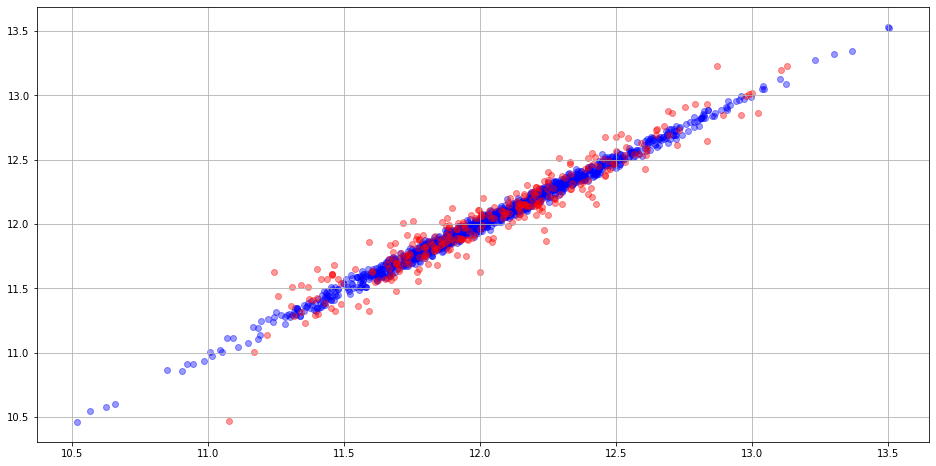

In [13]:
plt.figure(figsize=(16, 8))
plt.scatter(gs_gbm_fs.best_estimator_.predict(xtrain_fs), ytrain_fs, color='blue', alpha=0.4)
plt.scatter(gs_gbm_fs.best_estimator_.predict(xtest_fs), ytest_fs, color='red', alpha=0.4)
plt.grid(which='both')

In [15]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

# parameters to use
nestimators = [180, 190, 195, 200, 205, 210, 220, 230, 240]
sub_sample = [0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44]
minsamsplt = [4, 5, 6, 7, 8, 9]
minsamlf = [1, 2, 3, 4]
maxdepth = [1, 2, 3, 4, 5, 6, 7, 8]
warmstart = [True]

gparam_gbm_fs = {'n_estimators': nestimators,
                 'subsample': sub_sample,
                 'min_samples_split': minsamsplt,
                 'min_samples_leaf': minsamlf,
                 'max_depth': maxdepth,
                 'warm_start': warmstart}

# setting parameters
gs_gbm_fs = ms.GridSearchCV(gbm, gparam_gbm_fs, cv=n_folds, refit=True, n_jobs=-1,
                             scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_gbm_fs.fit(xtrain_fs, ytrain_fs)

# setting up dataframe for results
train_scores.append(gs_gbm_fs.best_estimator_.score(xtrain_fs, ytrain_fs))
test_scores.append(gs_gbm_fs.best_estimator_.score(xtest_fs, ytest_fs))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_gbm_fs, ytrain_fs, xtrain_fs))
test_rmse.append(rmse(gs_gbm_fs, ytest_fs, xtest_fs))

# add the best parameters to the df
best_par_list.append(gs_gbm_fs.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
gbm_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
gbm_res_df = pd.DataFrame(gbm_list_results).T
gbm_res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
gbm_res_df = pd.concat([gbm_res_df, best_par_df], axis=1, sort=False)

gbm_res_df

Wall time: 29min 10s


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,max_depth,min_samples_leaf,min_samples_split,n_estimators,subsample,warm_start
0,0.952866,0.928059,0.086051,0.110418,-0.024367,2,2,9,240,0.44,True


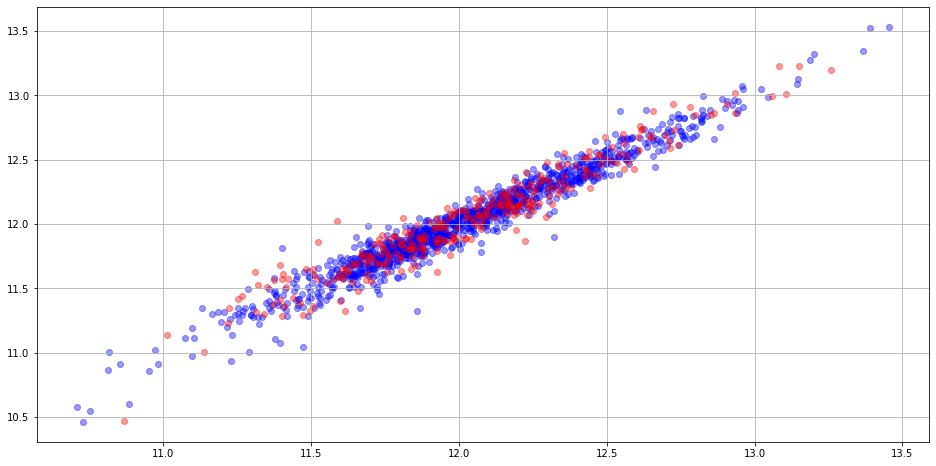

In [16]:
plt.figure(figsize=(16, 8))
plt.scatter(gs_gbm_fs.best_estimator_.predict(xtrain_fs), ytrain_fs, color='blue', alpha=0.4)
plt.scatter(gs_gbm_fs.best_estimator_.predict(xtest_fs), ytest_fs, color='red', alpha=0.4)
plt.grid(which='both')

In [23]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

# parameters to use
nestimators = [238, 239, 240, 241, 242, 243, 244]
sub_sample = [0.436, 0.437, 0.438, 0.439, 0.44, 0.441, 0.442, 0.443, 0.444]
minsamsplt = [7, 8, 9, 10, 11]
minsamlf = [1, 2, 3, 4, 5]
maxdepth = [1, 2, 3, 4, 5, 6]
warmstart = [True]

gparam_gbm_fs = {'n_estimators': nestimators,
                 'subsample': sub_sample,
                 'min_samples_split': minsamsplt,
                 'min_samples_leaf': minsamlf,
                 'max_depth': maxdepth,
                 'warm_start': warmstart}

# setting parameters
gs_gbm_fs = ms.GridSearchCV(gbm, gparam_gbm_fs, cv=n_folds, refit=True, n_jobs=-1,
                             scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_gbm_fs.fit(xtrain_fs, ytrain_fs)

# setting up dataframe for results
train_scores.append(gs_gbm_fs.best_estimator_.score(xtrain_fs, ytrain_fs))
test_scores.append(gs_gbm_fs.best_estimator_.score(xtest_fs, ytest_fs))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_gbm_fs, ytrain_fs, xtrain_fs))
test_rmse.append(rmse(gs_gbm_fs, ytest_fs, xtest_fs))

# add the best parameters to the df
best_par_list.append(gs_gbm_fs.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
gbm_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
gbm_res_df = pd.DataFrame(gbm_list_results).T
gbm_res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
gbm_res_df = pd.concat([gbm_res_df, best_par_df], axis=1, sort=False)

gbm_res_df

Wall time: 18min 2s


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,max_depth,min_samples_leaf,min_samples_split,n_estimators,subsample,warm_start
0,0.95298,0.928083,0.085947,0.1104,-0.024453,2,2,9,242,0.44,True


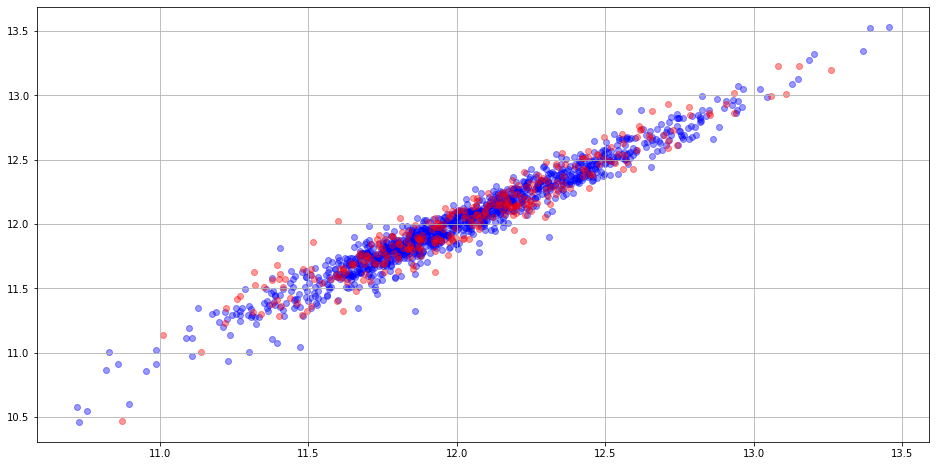

In [24]:
plt.figure(figsize=(16, 8))
plt.scatter(gs_gbm_fs.best_estimator_.predict(xtrain_fs), ytrain_fs, color='blue', alpha=0.4)
plt.scatter(gs_gbm_fs.best_estimator_.predict(xtest_fs), ytest_fs, color='red', alpha=0.4)
plt.grid(which='both')

# Experimental

In [10]:
gbm_experimental = copy.deepcopy(gbm_df)

# Adding Seasons
experiment = copy.deepcopy(combo)

# to_num = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6,
#           'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}

# experiment['MoSold'] = experiment['MoSold'].map(to_num)

experiment['SeasonSold'] = 'Spring'

experiment.loc[(experiment['MoSold']==6) |
               (experiment['MoSold']==7) | 
               (experiment['MoSold']==8), 'SeasonSold'] = 'Summer'

experiment.loc[(experiment['MoSold']==9) |
               (experiment['MoSold']==10) |
               (experiment['MoSold']==11), 'SeasonSold'] = 'Fall'

experiment.loc[(experiment['MoSold']==12) | 
               (experiment['MoSold']==1) | 
               (experiment['MoSold']==2), 'SeasonSold'] = 'Winter'

# changing combo now so that I could use month number in experiment df
# https://stackoverflow.com/questions/37625334/python-pandas-convert-month-int-to-month-name
import calendar

# Adding Sold Date

experiment[['MoSold', 'YrSold']] = experiment[['MoSold', 'YrSold']].astype(int)

experiment['DateSold'] = pd.to_datetime(experiment.YrSold.astype(str) +\
                                        '-' + experiment.MoSold.astype(str))

experiment['MoSold'] = experiment ['MoSold'].apply(lambda x: calendar.month_abbr[x])

# adding WSJ Prime Rate
# https://en.wikipedia.org/wiki/Wall_Street_Journal_prime_rate
experiment['WSJPrime'] = 0
experiment.loc[experiment['DateSold']>='2005-12-01 00:00:00', 'WSJPrime'] = 7.25
experiment.loc[experiment['DateSold']>='2006-02-01 00:00:00', 'WSJPrime'] = 7.50
experiment.loc[experiment['DateSold']>='2006-04-01 00:00:00', 'WSJPrime'] = 7.75
experiment.loc[experiment['DateSold']>='2006-05-01 00:00:00', 'WSJPrime'] = 8.00
experiment.loc[experiment['DateSold']>='2006-07-01 00:00:00', 'WSJPrime'] = 8.25
experiment.loc[experiment['DateSold']>='2007-09-01 00:00:00', 'WSJPrime'] = 7.75
experiment.loc[experiment['DateSold']>='2007-11-01 00:00:00', 'WSJPrime'] = 7.50
experiment.loc[experiment['DateSold']>='2007-12-01 00:00:00', 'WSJPrime'] = 7.25
experiment.loc[experiment['DateSold']>='2008-01-01 00:00:00', 'WSJPrime'] = 6.50
experiment.loc[experiment['DateSold']>='2008-02-01 00:00:00', 'WSJPrime'] = 6.00
experiment.loc[experiment['DateSold']>='2008-03-01 00:00:00', 'WSJPrime'] = 5.25
experiment.loc[experiment['DateSold']>='2008-05-01 00:00:00', 'WSJPrime'] = 5.00
experiment.loc[experiment['DateSold']>='2008-10-01 00:00:00', 'WSJPrime'] = 4.50
experiment.loc[experiment['DateSold']>='2008-11-01 00:00:00', 'WSJPrime'] = 4.00
experiment.loc[experiment['DateSold']>='2008-12-01 00:00:00', 'WSJPrime'] = 3.25
experiment.loc[experiment['DateSold']>='2015-12-01 00:00:00', 'WSJPrime'] = 3.50

# for experimental dataset
to_paste = experiment[['DateSold', 'WSJPrime', 'MoSold', 'YrSold']]

gbm_df = gbm_df.drop(['MoSold'], axis=1)

new_cols = list(gbm_df.columns) + list(to_paste.columns)

gbm_experiment = pd.DataFrame(np.concatenate((gbm_df.loc[hp_index], to_paste.loc[hp_index]),
                                             axis=1), columns = new_cols)

# converting columns containing numbers to numeric type
for col in gbm_experiment.columns: 
    gbm_experiment[col] = gbm_experiment[col].astype('float', errors='ignore')

# dummify and scale the dataset
hp_experimental = copy.deepcopy(dum_scale(gbm_experiment))
hp_experimental_to_use = copy.deepcopy(hp_experimental.loc[hp_index])

hp_experimental_to_use

,TotalBsmtBaths,TotalBaths,BsmtFin,LotFrontage,LotArea,Street,Alley,Utilities,OverallQual,OverallCond,YearBuilt,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,PoolQC,Fence,MiscVal,DateSold,WSJPrime,YrSold,MSSubClass_1_1_2_STORY_UNFINISHED_ALL_AGES,MSSubClass_1_STORY_1945_OLDER,MSSubClass_1_STORY_1946_NEWER_ALL_STYLES,MSSubClass_1_STORY_PUD_Planned_Unit_Development_1946_NEWER,MSSubClass_1_STORY_W_FINISHED_ATTIC_ALL_AGES,MSSubClass_2_1_2_STORY_ALL_AGES,MSSubClass_2_FAMILY_CONVERSION_ALL_STYLES_AND_AGES,MSSubClass_2_STORY_1945_OLDER,MSSubClass_2_STORY_1946_NEWER,MSSubClass_2_STORY_PUD_1946_NEWER,MSSubClass_DUPLEX_ALL_STYLES_AND_AGES,MSSubClass_PUD_MULTILEVEL_INCL_SPLIT_LEV_FOYER,MSSubClass_SPLIT_FOYER,MSSubClass_SPLIT_OR_MULTI_LEVEL,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRA,Condition1_RRN,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRA,Condition2_RRN,BldgType_2fmCon,BldgType_Duplex,BldgType_TwnhsE,BldgType_TwnhsI,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_BrkComm,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CemntBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_WdShing,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MoSold_Aug,MoSold_Dec,MoSold_Feb,MoSold_Jan,MoSold_Jul,MoSold_Jun,MoSold_Mar,MoSold_May,MoSold_Nov,MoSold_Oct,MoSold_Sep
0,0.333333,0.714286,1.0,0.150685,0.033420,1.0,0.0,1.0,0.666667,0.500,0.949275,0.122500,0.666667,0.50,0.8,0.75,0.25,1.000000,0.322669,0.166667,0.000000,0.064212,0.266999,1.00,1.0,1.00,0.180373,0.413559,0.0,0.332207,0.666667,0.5,0.375,0.333333,0.666667,0.500000,1.000000,0.000000,0.9

In [28]:
experiment

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SeasonSold
0,2_STORY_1946_NEWER,RL,65.0,8450.0,1.0,0.0,Reg,Lvl,3.0,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,2003.0,2003.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,4.0,3.0,PConc,4.0,3.0,1.0,6.0,706.0,1.0,0.0,150.0,856.0,GasA,5.0,1.0,5.0,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,4.0,8.0,7.0,0.0,None,Attchd,2003.0,2.0,2.0,548.0,3.0,3.0,3.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,NaN,2008.0,WD,Normal,Spring
1,1_STORY_1946_NEWER_ALL_STYLES,RL,80.0,9600.0,1.0,0.0,Reg,Lvl,3.0,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6.0,8.0,1976.0,1976.0,Gable,CompShg,MetalSd,MetalSd,None,0.0,3.0,3.0,CBlock,4.0,3.0,4.0,5.0,978.0,1.0,0.0,284.0,1262.0,GasA,5.0,1.0,5.0,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,3.0,6.0,7.0,1.0,TA,Attchd,1976.0,2.0,2.0,460.0,3.0,3.0,3.0,298.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,NaN,2007.0,WD,Normal,Spring
2,2_STORY_1946_NEWER,RL,68.0,11250.0,1.0,0.0,IR1,Lvl,3.0,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,2001.0,2002.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,4.0,3.0,PConc,4.0,3.0,2.0,6.0,486.0,1.0,0.0,434.0,920.0,GasA,5.0,1.0,5.0,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,4.0,6.0,7.0,1.0,TA,Attchd,2001.0,2.0,2.0,608.0,3.0,3.0,3.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,NaN,2008.0,WD,Normal,Spring
3,2_STORY_1945_OLDER,RL,60.0,9550.0,1.0,0.0,IR1,Lvl,3.0,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7.0,5.0,1915.0,1970.0,Gable,CompShg,Wd Sdng,WdShing,None,0.0,3.0,3.0,BrkTil,3.0,4.0,1.0,5.0,216.0,1.0,0.0,540.0,756.0,GasA,4.0,1.0,5.0,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,4.0,7.0,7.0,1.0,Gd,Detchd,1998.0,1.0,3.0,642.0,3.0,3.0,3.0,0.0,35.0,272.0,0.0,0.0,0.0,0.0,0.0,None,0.0,NaN,2006.0,WD,Abnorml,Spring
4,2_STORY_1946_NEWER,RL,84.0,14260.0,1.0,0.0,IR1,Lvl,3.0,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8.0,5.0,2000.0,2000.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,4.0,3.0,PConc,4.0,3.0,3.0,6.0,655.0,1.0,0.0,490.0,1145.0,GasA,5.0,1.0,5.0,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,4.0,9.0,7.0,1.0,TA,Attchd,2000.0,2.0,3.0,836.0,3.0,3.0,3.0,192.0,84.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,NaN,2008.0,WD,Normal,Spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2912,2_STORY_PUD_1946_NEWER,RM,21.0,1936.0,1.0,0.0,Reg,Lvl,3.0,Inside,Gtl,MeadowV,Norm,Norm,TwnhsI,2Story,4.0,7.0,1970.0,1970.0,Gable,CompShg,CemntBd,CemntBd,None,0.0,3.0,3.0,CBlock,3.0,3.0,1.0,1.0,0.0,1.0,0.0,546.0,546.0,GasA,4.0,1.0,5.0,546.0,546.0,0.0,1092.0,0.0,0.0,1.0,1.0,3.0,1.0,3.0,5.0,7.0,0.0,None,None,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,NaN,2006.0,WD,Normal,Spring
2913,2_STORY_PUD_1946_NEWER,RM,21.0,1894.0,1.0,0.0,Reg,Lvl,3.0,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4.0,5.0,1970.0,1970.0,Gable,CompShg,CemntBd,CemntBd,None,0.0,3.0,3.0,CBlock,3.0,3.0,1.0,3.0,252.0,1.0,0.0,294.0,546.0,GasA,3.0,1.0,5.0,546.0,546.0,0.0,1092.0,0.0,0.0,1.0,1.0,3.0,1.0,3.0,6.0,7.0,0.0,None,CarPort,1970.0,1.0,1.0,286.0,3.0,

In [26]:
state = 0

# setting up train and test sets
xtrain_exp, xtest_exp, ytrain_exp, ytest_exp = ms.train_test_split(hp_experimental_to_use,
                                                                   hp_logsp,
                                                                   test_size=0.2,
                                                                   random_state=state)

# Must flatten to fit
ytrain_exp = ytrain_exp.values.flatten()

# using standard kfold split
n_folds = ms.KFold(n_splits=5, random_state=state, shuffle=True)

In [27]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

gbm = GradientBoostingRegressor(random_state=0)

# parameters to use
nestimators = [10, 20, 50, 100, 150, 200, 250]
sub_sample = [0.1, 0.25, 0.5, 0.75, 1]
minsamsplt = [2, 3, 4, 5]
minsamlf = [1, 2, 3, 4, 5]
maxdepth = [1, 2, 5, 7, 10]
warmstart = [True]

gparam_gbm_exp = {'n_estimators': nestimators,
                  'subsample': sub_sample,
                  'min_samples_split': minsamsplt,
                  'min_samples_leaf': minsamlf,
                  'max_depth': maxdepth,
                  'warm_start': warmstart}

# setting parameters
gs_gbm_exp = ms.GridSearchCV(gbm, gparam_gbm_exp, cv=n_folds, refit=True, n_jobs=-1,
                             scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_gbm_exp.fit(xtrain_exp, ytrain_exp)

# setting up dataframe for results
train_scores.append(gs_gbm_exp.best_estimator_.score(xtrain_exp, ytrain_exp))
test_scores.append(gs_gbm_exp.best_estimator_.score(xtest_exp, ytest_exp))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_gbm_exp, ytrain_exp, xtrain_exp))
test_rmse.append(rmse(gs_gbm_exp, ytest_exp, xtest_exp))

# add the best parameters to the df
best_par_list.append(gs_gbm_exp.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
gbm_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
gbm_res_df = pd.DataFrame(gbm_list_results).T
gbm_res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
gbm_res_df = pd.concat([gbm_res_df, best_par_df], axis=1, sort=False)

gbm_res_df

Wall time: 5min 52s


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,max_depth,min_samples_leaf,min_samples_split,n_estimators,subsample,warm_start
0,0.953576,0.927566,0.0854,0.110796,-0.025396,2,5,2,250,0.75,True


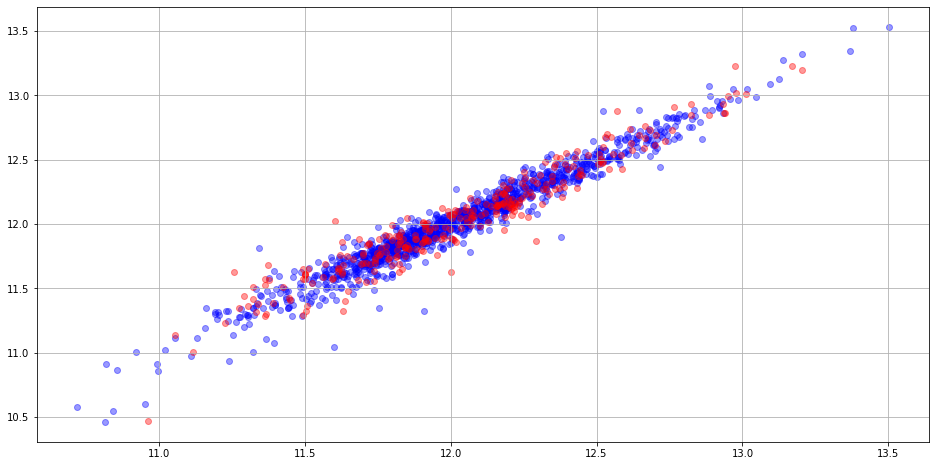

In [28]:
plt.figure(figsize=(16, 8))
plt.scatter(gs_gbm_exp.best_estimator_.predict(xtrain_exp), ytrain_exp, color='blue', alpha=0.4)
plt.scatter(gs_gbm_exp.best_estimator_.predict(xtest_exp), ytest_exp, color='red', alpha=0.4)
plt.grid(which='both')

In [29]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

gbm = GradientBoostingRegressor(random_state=0)

# parameters to use
nestimators = [230, 240, 250, 260, 270]
sub_sample = [0.1, 0.25, 0.5, 0.75, 1]
minsamsplt = [2, 3, 4, 5]
minsamlf = [1, 2, 3, 4, 5, 6, 7, 8]
maxdepth = [1, 2, 3, 4, 5]
warmstart = [True]

gparam_gbm_exp = {'n_estimators': nestimators,
                  'subsample': sub_sample,
                  'min_samples_split': minsamsplt,
                  'min_samples_leaf': minsamlf,
                  'max_depth': maxdepth,
                  'warm_start': warmstart}

# setting parameters
gs_gbm_exp = ms.GridSearchCV(gbm, gparam_gbm_exp, cv=n_folds, refit=True, n_jobs=-1,
                             scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_gbm_exp.fit(xtrain_exp, ytrain_exp)

# setting up dataframe for results
train_scores.append(gs_gbm_exp.best_estimator_.score(xtrain_exp, ytrain_exp))
test_scores.append(gs_gbm_exp.best_estimator_.score(xtest_exp, ytest_exp))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_gbm_exp, ytrain_exp, xtrain_exp))
test_rmse.append(rmse(gs_gbm_exp, ytest_exp, xtest_exp))

# add the best parameters to the df
best_par_list.append(gs_gbm_exp.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
gbm_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
gbm_res_df = pd.DataFrame(gbm_list_results).T
gbm_res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
gbm_res_df = pd.concat([gbm_res_df, best_par_df], axis=1, sort=False)

gbm_res_df

Wall time: 9min 31s


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,max_depth,min_samples_leaf,min_samples_split,n_estimators,subsample,warm_start
0,0.982318,0.932642,0.052705,0.106843,-0.054139,3,2,2,250,0.75,True


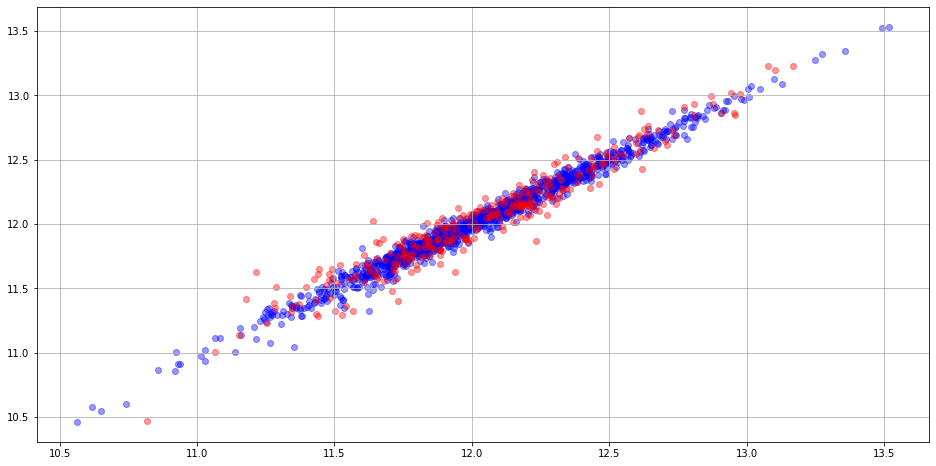

In [30]:
plt.figure(figsize=(16, 8))
plt.scatter(gs_gbm_exp.best_estimator_.predict(xtrain_exp), ytrain_exp, color='blue', alpha=0.4)
plt.scatter(gs_gbm_exp.best_estimator_.predict(xtest_exp), ytest_exp, color='red', alpha=0.4)
plt.grid(which='both')

In [31]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

gbm = GradientBoostingRegressor(random_state=0)

# parameters to use
nestimators = [241, 245, 250, 255, 259]
sub_sample = [0.5, 0.75, 1]
minsamsplt = [2, 3, 4, 5]
minsamlf = [1, 2, 3, 4, 5, 6]
maxdepth = [2, 3, 4, 5]
warmstart = [True]

gparam_gbm_exp = {'n_estimators': nestimators,
                  'subsample': sub_sample,
                  'min_samples_split': minsamsplt,
                  'min_samples_leaf': minsamlf,
                  'max_depth': maxdepth,
                  'warm_start': warmstart}

# setting parameters
gs_gbm_exp = ms.GridSearchCV(gbm, gparam_gbm_exp, cv=n_folds, refit=True, n_jobs=-1,
                             scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_gbm_exp.fit(xtrain_exp, ytrain_exp)

# setting up dataframe for results
train_scores.append(gs_gbm_exp.best_estimator_.score(xtrain_exp, ytrain_exp))
test_scores.append(gs_gbm_exp.best_estimator_.score(xtest_exp, ytest_exp))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_gbm_exp, ytrain_exp, xtrain_exp))
test_rmse.append(rmse(gs_gbm_exp, ytest_exp, xtest_exp))

# add the best parameters to the df
best_par_list.append(gs_gbm_exp.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
gbm_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
gbm_res_df = pd.DataFrame(gbm_list_results).T
gbm_res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
gbm_res_df = pd.concat([gbm_res_df, best_par_df], axis=1, sort=False)

gbm_res_df

Wall time: 5min 33s


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,max_depth,min_samples_leaf,min_samples_split,n_estimators,subsample,warm_start
0,0.981424,0.932889,0.054021,0.106647,-0.052627,3,2,2,241,0.75,True


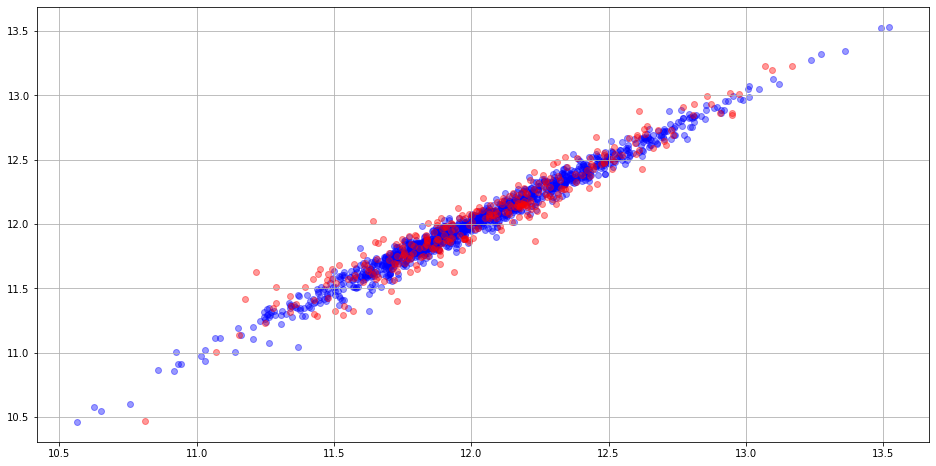

In [32]:
plt.figure(figsize=(16, 8))
plt.scatter(gs_gbm_exp.best_estimator_.predict(xtrain_exp), ytrain_exp, color='blue', alpha=0.4)
plt.scatter(gs_gbm_exp.best_estimator_.predict(xtest_exp), ytest_exp, color='red', alpha=0.4)
plt.grid(which='both')

In [33]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

gbm = GradientBoostingRegressor(random_state=0)

# parameters to use
nestimators = [236, 237, 238, 239, 240, 241, 245, 246, 247, 248, 249]
sub_sample = [0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
minsamsplt = [2, 3, 4]
minsamlf = [1, 2, 3, 4]
maxdepth = [2, 3, 4]
warmstart = [True]

gparam_gbm_exp = {'n_estimators': nestimators,
                  'subsample': sub_sample,
                  'min_samples_split': minsamsplt,
                  'min_samples_leaf': minsamlf,
                  'max_depth': maxdepth,
                  'warm_start': warmstart}

# setting parameters
gs_gbm_exp = ms.GridSearchCV(gbm, gparam_gbm_exp, cv=n_folds, refit=True, n_jobs=-1,
                             scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_gbm_exp.fit(xtrain_exp, ytrain_exp)

# setting up dataframe for results
train_scores.append(gs_gbm_exp.best_estimator_.score(xtrain_exp, ytrain_exp))
test_scores.append(gs_gbm_exp.best_estimator_.score(xtest_exp, ytest_exp))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_gbm_exp, ytrain_exp, xtrain_exp))
test_rmse.append(rmse(gs_gbm_exp, ytest_exp, xtest_exp))

# add the best parameters to the df
best_par_list.append(gs_gbm_exp.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
gbm_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
gbm_res_df = pd.DataFrame(gbm_list_results).T
gbm_res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
gbm_res_df = pd.concat([gbm_res_df, best_par_df], axis=1, sort=False)

gbm_res_df

Wall time: 11min 35s


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,max_depth,min_samples_leaf,min_samples_split,n_estimators,subsample,warm_start
0,0.981424,0.932889,0.054021,0.106647,-0.052627,3,2,2,241,0.75,True


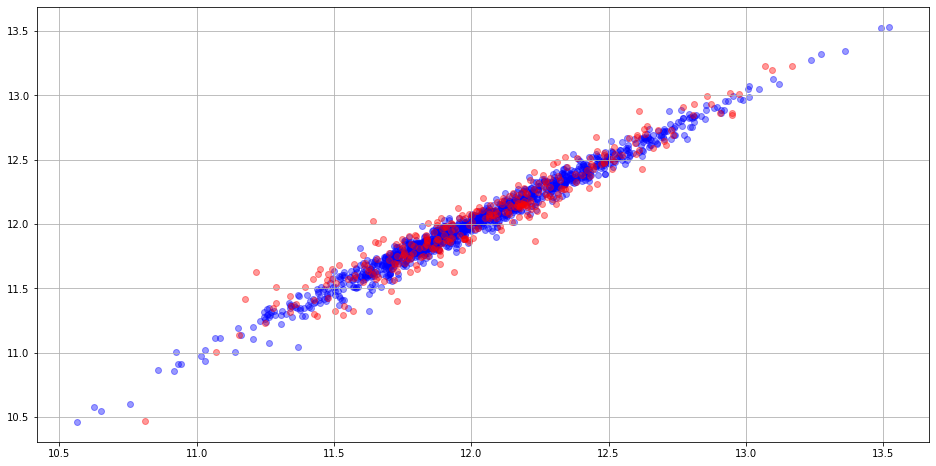

In [34]:
plt.figure(figsize=(16, 8))
plt.scatter(gs_gbm_exp.best_estimator_.predict(xtrain_exp), ytrain_exp, color='blue', alpha=0.4)
plt.scatter(gs_gbm_exp.best_estimator_.predict(xtest_exp), ytest_exp, color='red', alpha=0.4)
plt.grid(which='both')

In [35]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

gbm = GradientBoostingRegressor(random_state=0)

# parameters to use
nestimators = [239, 240, 241, 242, 243, 244]
sub_sample = [0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79]
minsamsplt = [2, 3, 4]
minsamlf = [1, 2, 3, 4]
maxdepth = [2, 3, 4]
warmstart = [True]

gparam_gbm_exp = {'n_estimators': nestimators,
                  'subsample': sub_sample,
                  'min_samples_split': minsamsplt,
                  'min_samples_leaf': minsamlf,
                  'max_depth': maxdepth,
                  'warm_start': warmstart}

# setting parameters
gs_gbm_exp = ms.GridSearchCV(gbm, gparam_gbm_exp, cv=n_folds, refit=True, n_jobs=-1,
                             scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_gbm_exp.fit(xtrain_exp, ytrain_exp)

# setting up dataframe for results
train_scores.append(gs_gbm_exp.best_estimator_.score(xtrain_exp, ytrain_exp))
test_scores.append(gs_gbm_exp.best_estimator_.score(xtest_exp, ytest_exp))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_gbm_exp, ytrain_exp, xtrain_exp))
test_rmse.append(rmse(gs_gbm_exp, ytest_exp, xtest_exp))

# add the best parameters to the df
best_par_list.append(gs_gbm_exp.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
gbm_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
gbm_res_df = pd.DataFrame(gbm_list_results).T
gbm_res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
gbm_res_df = pd.concat([gbm_res_df, best_par_df], axis=1, sort=False)

gbm_res_df

Wall time: 6min 20s


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,max_depth,min_samples_leaf,min_samples_split,n_estimators,subsample,warm_start
0,0.980706,0.928842,0.055054,0.109816,-0.054761,3,1,3,243,0.74,True


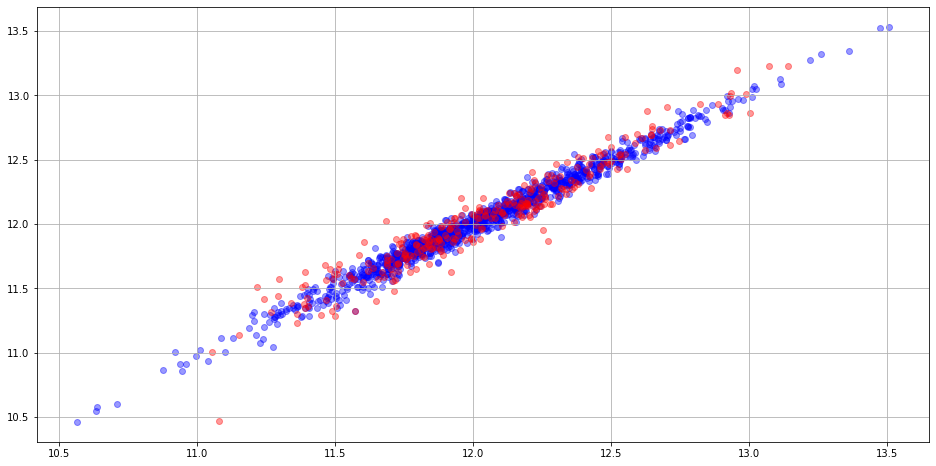

In [36]:
plt.figure(figsize=(16, 8))
plt.scatter(gs_gbm_exp.best_estimator_.predict(xtrain_exp), ytrain_exp, color='blue', alpha=0.4)
plt.scatter(gs_gbm_exp.best_estimator_.predict(xtest_exp), ytest_exp, color='red', alpha=0.4)
plt.grid(which='both')

# BEST PARAM

In [ ]:
# make copies of the original df to edit each individually according to the best scores/feat eng pair
gbm_df = copy.deepcopy(combo_nonedit)

# copy and paste the functions from the dictionary results above
gbm_feat_eng = [bsmtfin_add, totalbaths_add, totalbsmtbaths_add, conditions_edit, drop_porches, 
                drop_yrsoldremod, drop_poolarea, drop_bsmtbaths]

for feat in gbm_feat_eng:
    feat(gbm_df)

# dummify and scale the dataset
hp_full_strd = copy.deepcopy(dum_scale(gbm_df))

hp_full_strd_to_use = copy.deepcopy(hp_full_strd.loc[hp_index])


gbm_experimental = copy.deepcopy(gbm_df)

# Adding Seasons
experiment = copy.deepcopy(combo)

to_num = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6,
          'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}

experiment['MoSold'] = experiment['MoSold'].map(to_num)

experiment['SeasonSold'] = 'Spring'

experiment.loc[(experiment['MoSold']==6) |
               (experiment['MoSold']==7) | 
               (experiment['MoSold']==8), 'SeasonSold'] = 'Summer'

experiment.loc[(experiment['MoSold']==9) |
               (experiment['MoSold']==10) |
               (experiment['MoSold']==11), 'SeasonSold'] = 'Fall'

experiment.loc[(experiment['MoSold']==12) | 
               (experiment['MoSold']==1) | 
               (experiment['MoSold']==2), 'SeasonSold'] = 'Winter'

# changing combo now so that I could use month number in experiment df
# https://stackoverflow.com/questions/37625334/python-pandas-convert-month-int-to-month-name
import calendar

# Adding Sold Date

experiment[['MoSold', 'YrSold']] = experiment[['MoSold', 'YrSold']].astype(int)

experiment['DateSold'] = pd.to_datetime(experiment.YrSold.astype(str) +\
                                        '-' + experiment.MoSold.astype(str))

experiment['MoSold'] = experiment ['MoSold'].apply(lambda x: calendar.month_abbr[x])

# adding WSJ Prime Rate
# https://en.wikipedia.org/wiki/Wall_Street_Journal_prime_rate
experiment['WSJPrime'] = 0
experiment.loc[experiment['DateSold']>='2005-12-01 00:00:00', 'WSJPrime'] = 7.25
experiment.loc[experiment['DateSold']>='2006-02-01 00:00:00', 'WSJPrime'] = 7.50
experiment.loc[experiment['DateSold']>='2006-04-01 00:00:00', 'WSJPrime'] = 7.75
experiment.loc[experiment['DateSold']>='2006-05-01 00:00:00', 'WSJPrime'] = 8.00
experiment.loc[experiment['DateSold']>='2006-07-01 00:00:00', 'WSJPrime'] = 8.25
experiment.loc[experiment['DateSold']>='2007-09-01 00:00:00', 'WSJPrime'] = 7.75
experiment.loc[experiment['DateSold']>='2007-11-01 00:00:00', 'WSJPrime'] = 7.50
experiment.loc[experiment['DateSold']>='2007-12-01 00:00:00', 'WSJPrime'] = 7.25
experiment.loc[experiment['DateSold']>='2008-01-01 00:00:00', 'WSJPrime'] = 6.50
experiment.loc[experiment['DateSold']>='2008-02-01 00:00:00', 'WSJPrime'] = 6.00
experiment.loc[experiment['DateSold']>='2008-03-01 00:00:00', 'WSJPrime'] = 5.25
experiment.loc[experiment['DateSold']>='2008-05-01 00:00:00', 'WSJPrime'] = 5.00
experiment.loc[experiment['DateSold']>='2008-10-01 00:00:00', 'WSJPrime'] = 4.50
experiment.loc[experiment['DateSold']>='2008-11-01 00:00:00', 'WSJPrime'] = 4.00
experiment.loc[experiment['DateSold']>='2008-12-01 00:00:00', 'WSJPrime'] = 3.25
experiment.loc[experiment['DateSold']>='2015-12-01 00:00:00', 'WSJPrime'] = 3.50

# for experimental dataset
to_paste = experiment[['DateSold', 'WSJPrime', 'MoSold', 'YrSold']]

gbm_df = gbm_df.drop(['MoSold'], axis=1)

new_cols = list(gbm_df.columns) + list(to_paste.columns)

gbm_experiment = pd.DataFrame(np.concatenate((gbm_df.loc[hp_index], to_paste.loc[hp_index]),
                                             axis=1), columns = new_cols)

# converting columns containing numbers to numeric type
for col in gbm_experiment.columns: 
    gbm_experiment[col] = gbm_experiment[col].astype('float', errors='ignore')

# dummify and scale the dataset
hp_experimental = copy.deepcopy(dum_scale(gbm_experiment))
hp_experimental_to_use = copy.deepcopy(hp_experimental.loc[hp_index])

state = 0

# setting up train and test sets
xtrain, xtest, ytrain, ytest = ms.train_test_split(hp_experimental_to_use,
                                                   hp_logsp,
                                                   test_size=0.2,
                                                   random_state=state)

# Must flatten to fit
ytrain = ytrain.values.flatten()

# using standard kfold split
n_folds = ms.KFold(n_splits=5, random_state=state, shuffle=True)

gbm = RandomForestRegressor(random_state=0)

# parameters to use
maxdepth = [3]
minsamlf = [2]
minsamsplt = [2]
nestimators = [241]
sub_sample = [0.75]
warmstart = [True]

gparam_gbm = {'n_estimators': nestimators,
              'subsample': sub_sample,
              'min_samples_split': minsamsplt,
              'min_samples_leaf': minsamlf,
              'max_depth': maxdepth,
              'warm_start': warmstart}
# setting parameters
gs_gbm = ms.GridSearchCV(gbm, gparam_gbm, cv=n_folds, refit=True, n_jobs=-1,
                           scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_gbm.fit(xtrain, ytrain)